In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import re
from sklearn.metrics import pairwise_distances
from sacremoses import MosesDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from autocorrect import Speller
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

In [2]:
#Import South Park Script
southpark = pd.read_csv("All-seasons.csv")
southpark.head()

,Season,Episode,Character,Line
0,1,1,Boys,"School day, school day, teacher's golden ru...\n"
1,1,1,Kyle,"Ah, damn it! My little brother's trying to fol..."
2,1,1,Ike,Zeeponanner.\n
3,1,1,Kyle,"Ike, you can't come to school with me. \n"
4,1,1,Cartman,"Yeah, go home you little dildo.\n"


# Cartman

In [3]:
#Dialogue spoken by Cartman
cart = southpark['Character'] == 'Cartman'
cartman = southpark[cart]
cartman.head()

,Season,Episode,Character,Line
4,1,1,Cartman,"Yeah, go home you little dildo.\n"
8,1,1,Cartman,I know what it means!\n
10,1,1,Cartman,I'm not telling you.\n
13,1,1,Cartman,"He-yeah, that's what Kyle's little brother is ..."
19,1,1,Cartman,That's 'cause I was having these... bogus nigh...


In [4]:
#Reset index
cartman = cartman.reset_index(drop=True)
cartman.head()

,Season,Episode,Character,Line
0,1,1,Cartman,"Yeah, go home you little dildo.\n"
1,1,1,Cartman,I know what it means!\n
2,1,1,Cartman,I'm not telling you.\n
3,1,1,Cartman,"He-yeah, that's what Kyle's little brother is ..."
4,1,1,Cartman,That's 'cause I was having these... bogus nigh...


In [5]:
# Expand Contractions
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
cartman['Line_process'] = cartman['Line'].apply(decontracted)
cartman['Line_process'].head(25)

0                     Yeah, go home you little dildo.\n
1                               I know what it means!\n
2                               I am not telling you.\n
3     He-yeah, that is what Kyle is little brother i...
4     That is 'cause I was having these... bogus nig...
5     Well, I dreamt that I was lying in my bed...  ...
6                                               What?\n
7            No, it was just a dream, my mom said so.\n
8     Oh, shut up guys! You are just trying to make ...
9                                           Kick ass.\n
10                                               Huh?\n
11    Eh, no, that, that was just a dream. And I am ...
12                                                Oh!\n
13                                                Oh!\n
14         No! Uh-I mean, eh, why would they do that?\n
15                                                No!\n
16                                    Shut up, dildo!\n
17                                              

In [6]:
#Lowercase
cartman['Line_process'] = cartman['Line_process'].apply(lambda x: " ".join(x.lower() for x in x.split()))
cartman['Line_process'].head(25)

0                       yeah, go home you little dildo.
1                                 i know what it means!
2                                 i am not telling you.
3     he-yeah, that is what kyle is little brother i...
4     that is 'cause i was having these... bogus nig...
5     well, i dreamt that i was lying in my bed... i...
6                                                 what?
7              no, it was just a dream, my mom said so.
8     oh, shut up guys! you are just trying to make ...
9                                             kick ass.
10                                                 huh?
11    eh, no, that, that was just a dream. and i am ...
12                                                  oh!
13                                                  oh!
14           no! uh-i mean, eh, why would they do that?
15                                                  no!
16                                      shut up, dildo!
17                                              

In [7]:
#Remove numbers
cartman['Line_process'] = cartman['Line_process'].str.replace('\d+', '')
cartman['Line_process'].head(25)

0                       yeah, go home you little dildo.
1                                 i know what it means!
2                                 i am not telling you.
3     he-yeah, that is what kyle is little brother i...
4     that is 'cause i was having these... bogus nig...
5     well, i dreamt that i was lying in my bed... i...
6                                                 what?
7              no, it was just a dream, my mom said so.
8     oh, shut up guys! you are just trying to make ...
9                                             kick ass.
10                                                 huh?
11    eh, no, that, that was just a dream. and i am ...
12                                                  oh!
13                                                  oh!
14           no! uh-i mean, eh, why would they do that?
15                                                  no!
16                                      shut up, dildo!
17                                              

In [8]:
#Spellchecker
spell = Speller(lang='en')
cartman["Line_process"] = [' '.join([spell(i) for i in x.split()]) for x in cartman['Line_process']]
cartman['Line_process'].head(25)

0                       yeah, go home you little dildo.
1                                 i know what it means!
2                                 i am not telling you.
3     he-yeah, that is what kyle is little brother i...
4     that is 'cause i was having these... bogus nig...
5     well, i dreamt that i was lying in my bed... i...
6                                                 what?
7              no, it was just a dream, my mom said so.
8     oh, shut up guys! you are just trying to make ...
9                                             kick ass.
10                                                 huh?
11    eh, no, that, that was just a dream. and i am ...
12                                                  oh!
13                                                  oh!
14           no! uh-i mean, eh, why would they do that?
15                                                  no!
16                                      shut up, dildo!
17                                              

In [9]:
#Remove Stop Words
from nltk.corpus import stopwords
stop = stopwords.words('english')
cartman['Line_process'] = cartman['Line_process'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
cartman['Line_process'].head(25)

0                           yeah, go home little dildo.
1                                           know means!
2                                          telling you.
3               he-yeah, kyle little brother right! ow!
4                     'cause these... bogus nightmares.
5     well, dreamt lying bed... dark, sudden bright ...
6                                                 what?
7                               no, dream, mom said so.
8           oh, shut guys! trying make scared. working.
9                                             kick ass.
10                                                 huh?
11                 eh, no, that, dream. fat, big boned!
12                                                  oh!
13                                                  oh!
14                       no! uh-i mean, eh, would that?
15                                                  no!
16                                      shut up, dildo!
17                                              

In [10]:
#Remove Punctuation
cartman['Line_process'] = cartman['Line_process'].str.replace('[^\w\s]','')
cartman['Line_process'].head(25)

0                             yeah go home little dildo
1                                            know means
2                                           telling you
3                   heyeah kyle little brother right ow
4                          cause these bogus nightmares
5     well dreamt lying bed dark sudden bright blue ...
6                                                  what
7                                  no dream mom said so
8               oh shut guys trying make scared working
9                                              kick ass
10                                                  huh
11                       eh no that dream fat big boned
12                                                   oh
13                                                   oh
14                            no uhi mean eh would that
15                                                   no
16                                        shut up dildo
17                                              

In [11]:
#Tokenize
cartman['word_tokens'] = cartman['Line_process'].apply(word_tokenize)

In [12]:
cartman['word_tokens'].head(25)

0                       [yeah, go, home, little, dildo]
1                                         [know, means]
2                                        [telling, you]
3            [heyeah, kyle, little, brother, right, ow]
4                     [cause, these, bogus, nightmares]
5     [well, dreamt, lying, bed, dark, sudden, brigh...
6                                                [what]
7                            [no, dream, mom, said, so]
8       [oh, shut, guys, trying, make, scared, working]
9                                           [kick, ass]
10                                                [huh]
11               [eh, no, that, dream, fat, big, boned]
12                                                 [oh]
13                                                 [oh]
14                     [no, uhi, mean, eh, would, that]
15                                                 [no]
16                                    [shut, up, dildo]
17                                              

In [13]:
#Lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
cartman['word_tokens'].apply(lemmatize_text).head(25)

0                       [yeah, go, home, little, dildo]
1                                          [know, mean]
2                                        [telling, you]
3            [heyeah, kyle, little, brother, right, ow]
4                      [cause, these, bogus, nightmare]
5     [well, dreamt, lying, bed, dark, sudden, brigh...
6                                                [what]
7                            [no, dream, mom, said, so]
8        [oh, shut, guy, trying, make, scared, working]
9                                            [kick, as]
10                                                [huh]
11               [eh, no, that, dream, fat, big, boned]
12                                                 [oh]
13                                                 [oh]
14                     [no, uhi, mean, eh, would, that]
15                                                 [no]
16                                    [shut, up, dildo]
17                                              

In [14]:
#Convert Word Tokens to String
md = MosesDetokenizer(lang = 'en')
cartman['token_string'] = cartman['word_tokens'].apply(lambda x: md.detokenize(x, return_str=True))
cartman['token_string'].head(25)

0                             yeah go home little dildo
1                                            know means
2                                           telling you
3                   heyeah kyle little brother right ow
4                          cause these bogus nightmares
5     well dreamt lying bed dark sudden bright blue ...
6                                                  what
7                                  no dream mom said so
8               oh shut guys trying make scared working
9                                              kick ass
10                                                  huh
11                       eh no that dream fat big boned
12                                                   oh
13                                                   oh
14                            no uhi mean eh would that
15                                                   no
16                                        shut up dildo
17                                              

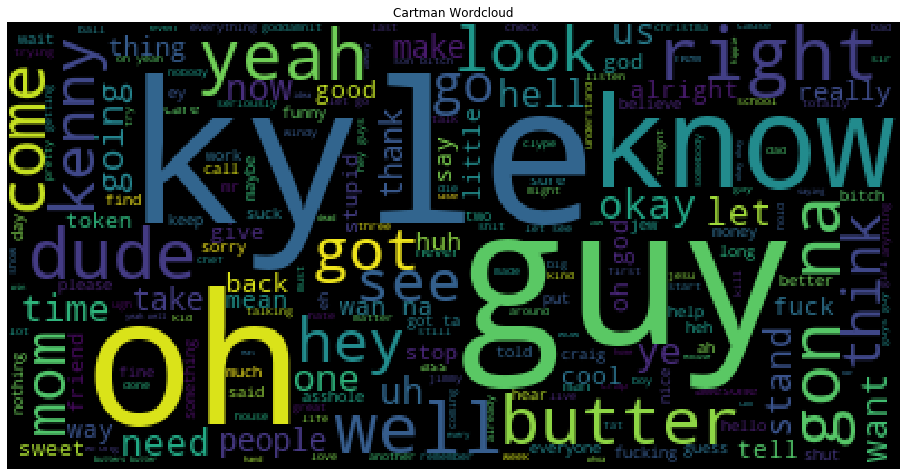

In [15]:
#Wordcloud
wordcloud_cartman = WordCloud().generate(cartman['word_tokens'].to_string())
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud_cartman)
plt.axis("off")
plt.savefig('Cartman_Wordcloud.png')
plt.title('Cartman Wordcloud')
plt.show()

In [16]:
cartman_lists =  cartman['word_tokens']
cartman_words = []
for cartman_wordList in cartman_lists:
    cartman_words += cartman_wordList
cartman_bigram = ngrams(cartman_words,2)
cartman_bigram_top = Counter(cartman_bigram).most_common(10)
for word, count in cartman_bigram_top:
    print(word, ":", count)

('gon', 'na') : 554
('come', 'on') : 178
('wan', 'na') : 176
('oh', 'god') : 145
('got', 'ta') : 109
('let', 'go') : 74
('right', 'now') : 68
('no', 'no') : 65
('thank', 'you') : 63
('let', 'see') : 59


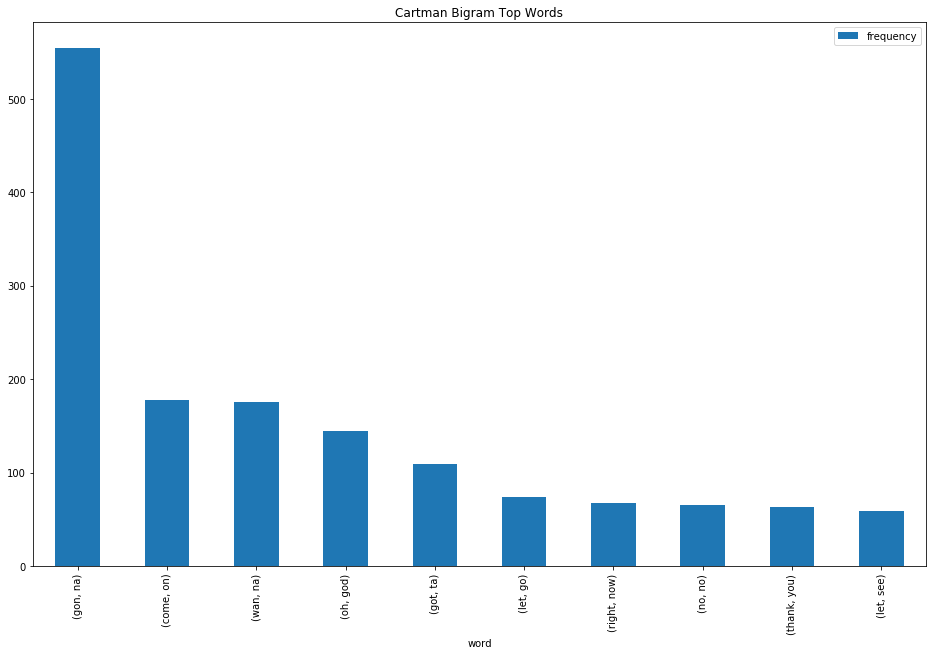

In [17]:
cartman_bi = pd.DataFrame(cartman_bigram_top, columns = ['word', 'frequency'])
cartman_bi.plot(kind='bar', x='word', figsize=(16,10), title='Cartman Bigram Top Words')
plt.savefig('Cartman_Bigram.png')

In [18]:
cartman_trigram = ngrams(cartman_words,3)
cartman_trigram_top = Counter(cartman_trigram).most_common(10)
for word, count in cartman_bigram_top:
    print(word, ":", count)

('gon', 'na') : 554
('come', 'on') : 178
('wan', 'na') : 176
('oh', 'god') : 145
('got', 'ta') : 109
('let', 'go') : 74
('right', 'now') : 68
('no', 'no') : 65
('thank', 'you') : 63
('let', 'see') : 59


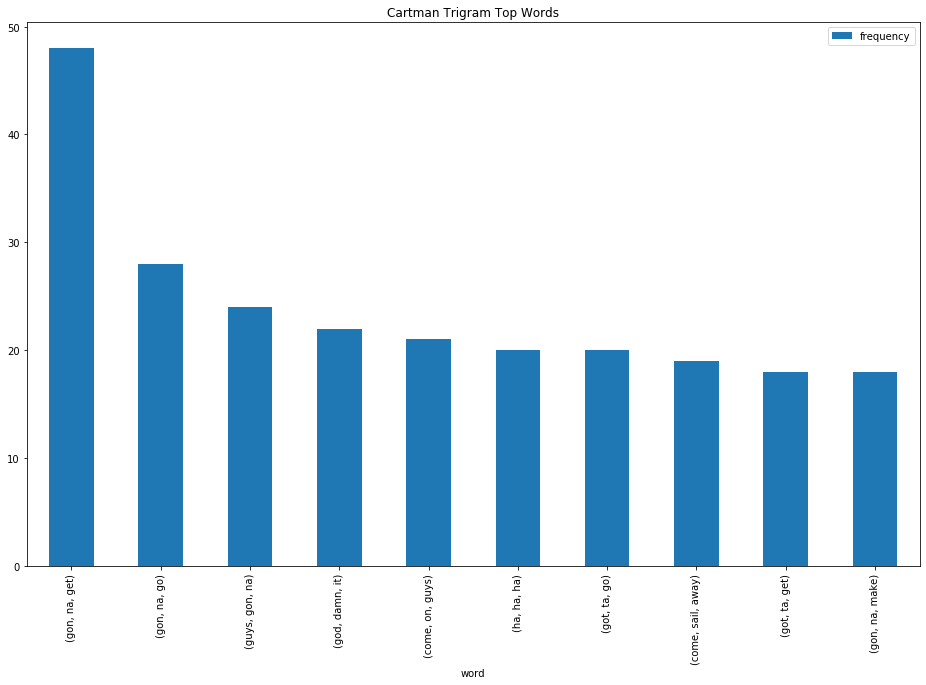

In [19]:
cartman_tri = pd.DataFrame(cartman_trigram_top, columns = ['word', 'frequency'])
cartman_tri.plot(kind='bar', x='word', figsize=(16,10), title='Cartman Trigram Top Words')
plt.savefig('Cartman_Trigram.png')

In [20]:
#Bag of Word Model

In [21]:
cartman_vec = CountVectorizer()
cartman_bag_of_words = cartman_vec.fit_transform(cartman['token_string'])
cartman_sum_words = cartman_bag_of_words.sum(axis=0)
cartman_words_freq = [(word, cartman_sum_words[0, idx]) for word, idx in cartman_vec.vocabulary_.items()]
cartman_words_freq = np.array(sorted(cartman_words_freq, key = lambda x: x[1], reverse=True))

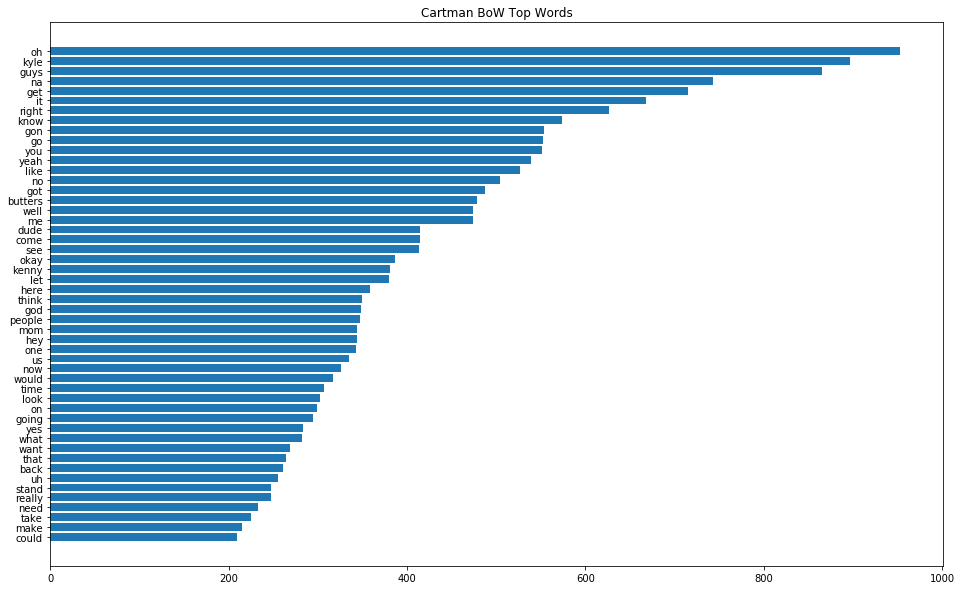

In [22]:
n = 50
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), cartman_words_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=cartman_words_freq[:n, 0])
plt.savefig('Cartman_BOW.png')
plt.title('Cartman BoW Top Words')
plt.show()

In [23]:
#Create New Dataframe of Bag of Words Array
cartman_bag = cartman_vec.fit_transform(cartman['token_string']).toarray()
cartman_bag_features = cartman_vec.get_feature_names()
cartman_bow = pd.DataFrame(cartman_bag, columns = cartman_bag_features)
cartman_bow.head()

,aa,aaa,aaaaaa,aaaaaaaa,aaaaaaaaaaaaaaaaa,aaaaaaaah,aaaaaaah,aaaaaduh,aaaaahhhh,aaaaaht,...,zipliiine,zippers,zombie,zombies,zoo,zookeeper,zoomed,zu,zzz,zzzzsssht
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#TF-IDF
cartman_vect = TfidfVectorizer()
cartman_tf = cartman_vect.fit_transform(cartman['token_string'])
cartman_sum_tfidf = cartman_tf.sum(axis=0)
cartman_tfidf_freq = [(word, cartman_sum_tfidf[0, idx]) for word, idx in cartman_vect.vocabulary_.items()]
cartman_tfidf_freq = np.array(sorted(cartman_tfidf_freq, key = lambda x: x[1], reverse=True))

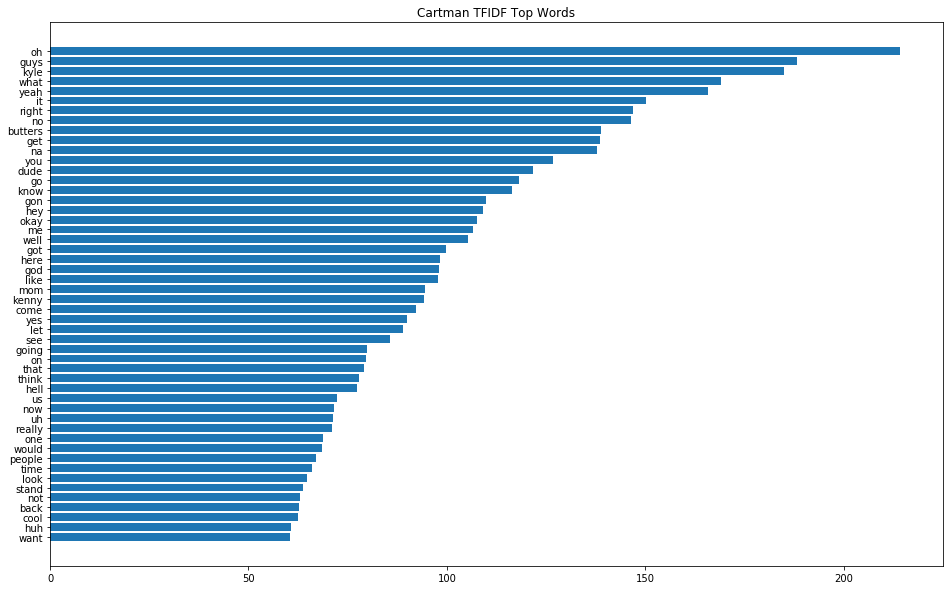

In [25]:
n = 50
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), cartman_tfidf_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=cartman_tfidf_freq[:n, 0])
plt.savefig('Cartman_TFIDF.png')
plt.title('Cartman TFIDF Top Words')
plt.show()

In [26]:
#Create New Dataframe of TFIDF Array
cartman_vectorize = cartman_vect.fit_transform(cartman['token_string']).toarray()
cartman_tfidf_features = cartman_vect.get_feature_names()
cartman_tfidf = pd.DataFrame(cartman_vectorize, columns = cartman_tfidf_features)
cartman_tfidf.head()

,aa,aaa,aaaaaa,aaaaaaaa,aaaaaaaaaaaaaaaaa,aaaaaaaah,aaaaaaah,aaaaaduh,aaaaahhhh,aaaaaht,...,zipliiine,zippers,zombie,zombies,zoo,zookeeper,zoomed,zu,zzz,zzzzsssht
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Preprocessing Function
def text_normalization(question):
    #Preprocessing
    #Expand Contractions
    question = decontracted(question)
    #Remove Punctuation
    question = re.sub(r'[^\w\s]','',question)
    #Lowercase
    question = str(question).lower()
    #Remove Numbers
    question = ''.join(i for i in question if not i.isdigit())
    #Spellchecker
    question = spell(question)
    #Tokenize
    question = word_tokenize(question)
    #Remove Stop Words
    question = [i for i in question if i not in stop]
    #Lemmatize
    question = lemmatize_text(question)
    #Detokenize
    question = md.detokenize(question)
    return question

# Kyle

In [28]:
#Dialogue spoken by Kyle
ky = southpark['Character'] == 'Kyle'
kyle = southpark[ky]
kyle.head()

,Season,Episode,Character,Line
1,1,1,Kyle,"Ah, damn it! My little brother's trying to fol..."
3,1,1,Kyle,"Ike, you can't come to school with me. \n"
5,1,1,Kyle,"Dude, don't call my brother a dildo!\n"
7,1,1,Kyle,"Well, I don't know... and I'll bet Cartman do..."
9,1,1,Kyle,"Well, what?\n"


In [29]:
#Reset index
kyle = kyle.reset_index(drop=True)
kyle.head()

,Season,Episode,Character,Line
0,1,1,Kyle,"Ah, damn it! My little brother's trying to fol..."
1,1,1,Kyle,"Ike, you can't come to school with me. \n"
2,1,1,Kyle,"Dude, don't call my brother a dildo!\n"
3,1,1,Kyle,"Well, I don't know... and I'll bet Cartman do..."
4,1,1,Kyle,"Well, what?\n"


In [30]:
# Expand Contractions
kyle['Line_process'] = kyle['Line'].apply(decontracted)
kyle['Line_process'].head(25)

0     Ah, damn it! My little brother is trying to fo...
1           Ike, you can not come to school with me. \n
2               Dude, do not call my brother a dildo!\n
3     Well, I do not know...  and I will bet Cartman...
4                                         Well, what?\n
5     Yeah, check this one out. Ready, Ike? Kick the...
6                                     Kick the baby. \n
7                                 Really? What about?\n
8                                            Totally!\n
9     Yeah, they abduct people and they mutilate cow...
10                              Yeah, fat boy saw it!\n
11                             What is an anal probe?\n
12         Whoa! They gave you an anal probe Cartman?\n
13    We told you they were real Cartman. Sorry to h...
14              Why are you walkin' so funny Cartman?\n
15                                  No, Ike, go home.\n
16              This is it. This one is for the game.\n
17                                    Kick the b

In [31]:
#Lowercase
kyle['Line_process'] = kyle['Line_process'].apply(lambda x: " ".join(x.lower() for x in x.split()))
kyle['Line_process'].head(25)

0     ah, damn it! my little brother is trying to fo...
1              ike, you can not come to school with me.
2                 dude, do not call my brother a dildo!
3     well, i do not know... and i will bet cartman ...
4                                           well, what?
5     yeah, check this one out. ready, ike? kick the...
6                                        kick the baby.
7                                   really? what about?
8                                              totally!
9      yeah, they abduct people and they mutilate cows.
10                                yeah, fat boy saw it!
11                               what is an anal probe?
12           whoa! they gave you an anal probe cartman?
13    we told you they were real cartman. sorry to h...
14                why are you walkin' so funny cartman?
15                                    no, ike, go home.
16                this is it. this one is for the game.
17                                       kick th

In [32]:
#Remove numbers
kyle['Line_process'] = kyle['Line_process'].str.replace('\d+', '')
kyle['Line_process'].head(25)

0     ah, damn it! my little brother is trying to fo...
1              ike, you can not come to school with me.
2                 dude, do not call my brother a dildo!
3     well, i do not know... and i will bet cartman ...
4                                           well, what?
5     yeah, check this one out. ready, ike? kick the...
6                                        kick the baby.
7                                   really? what about?
8                                              totally!
9      yeah, they abduct people and they mutilate cows.
10                                yeah, fat boy saw it!
11                               what is an anal probe?
12           whoa! they gave you an anal probe cartman?
13    we told you they were real cartman. sorry to h...
14                why are you walkin' so funny cartman?
15                                    no, ike, go home.
16                this is it. this one is for the game.
17                                       kick th

In [33]:
#Spellchecker
kyle["Line_process"] = [' '.join([spell(i) for i in x.split()]) for x in kyle['Line_process']]
kyle['Line_process'].head(25)

0     ah, damn it! my little brother is trying to fo...
1              ike, you can not come to school with me.
2                 dude, do not call my brother a dildo!
3     well, i do not know... and i will bet cartman ...
4                                           well, what?
5     yeah, check this one out. ready, ike? kick the...
6                                        kick the baby.
7                                   really? what about?
8                                              totally!
9      yeah, they abduct people and they mutilate cows.
10                                yeah, fat boy saw it!
11                               what is an anal probe?
12           whoa! they gave you an anal probe cartman?
13    we told you they were real cartman. sorry to h...
14               why are you walking' so funny cartman?
15                                    no, ike, go home.
16                this is it. this one is for the game.
17                                       kick th

In [34]:
#Remove Stop Words
kyle['Line_process'] = kyle['Line_process'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
kyle['Line_process'].head(25)

0     ah, damn it! little brother trying follow scho...
1                                  ike, come school me.
2                             dude, call brother dildo!
3                well, know... bet cartman know either!
4                                           well, what?
5           yeah, check one out. ready, ike? kick baby!
6                                            kick baby.
7                                        really? about?
8                                              totally!
9                    yeah, abduct people mutilate cows.
10                                yeah, fat boy saw it!
11                                          anal probe?
12                       whoa! gave anal probe cartman?
13                   told real cartman. sorry hear ass.
14                              walking' funny cartman?
15                                    no, ike, go home.
16                                        it. one game.
17                                           kic

In [35]:
#Remove Punctuation
kyle['Line_process'] = kyle['Line_process'].str.replace('[^\w\s]','')
kyle['Line_process'].head(25)

0     ah damn it little brother trying follow school...
1                                    ike come school me
2                               dude call brother dildo
3                     well know bet cartman know either
4                                             well what
5                yeah check one out ready ike kick baby
6                                             kick baby
7                                          really about
8                                               totally
9                      yeah abduct people mutilate cows
10                                  yeah fat boy saw it
11                                           anal probe
12                         whoa gave anal probe cartman
13                     told real cartman sorry hear ass
14                                walking funny cartman
15                                       no ike go home
16                                          it one game
17                                            ki

In [36]:
#Tokenize
kyle['word_tokens'] = kyle['Line_process'].apply(word_tokenize)

In [37]:
kyle['word_tokens'].head(25)

0     [ah, damn, it, little, brother, trying, follow...
1                               [ike, come, school, me]
2                          [dude, call, brother, dildo]
3              [well, know, bet, cartman, know, either]
4                                          [well, what]
5       [yeah, check, one, out, ready, ike, kick, baby]
6                                          [kick, baby]
7                                       [really, about]
8                                             [totally]
9                [yeah, abduct, people, mutilate, cows]
10                            [yeah, fat, boy, saw, it]
11                                        [anal, probe]
12                   [whoa, gave, anal, probe, cartman]
13              [told, real, cartman, sorry, hear, ass]
14                            [walking, funny, cartman]
15                                  [no, ike, go, home]
16                                      [it, one, game]
17                                         [kick

In [38]:
#Lemmatize
kyle['word_tokens'].apply(lemmatize_text).head(25)

0     [ah, damn, it, little, brother, trying, follow...
1                               [ike, come, school, me]
2                          [dude, call, brother, dildo]
3              [well, know, bet, cartman, know, either]
4                                          [well, what]
5       [yeah, check, one, out, ready, ike, kick, baby]
6                                          [kick, baby]
7                                       [really, about]
8                                             [totally]
9                 [yeah, abduct, people, mutilate, cow]
10                            [yeah, fat, boy, saw, it]
11                                        [anal, probe]
12                   [whoa, gave, anal, probe, cartman]
13               [told, real, cartman, sorry, hear, as]
14                            [walking, funny, cartman]
15                                  [no, ike, go, home]
16                                      [it, one, game]
17                                         [kick

In [39]:
#Convert Word Tokens to String
kyle['token_string'] = kyle['word_tokens'].apply(lambda x: md.detokenize(x, return_str=True))
kyle['token_string'].head(25)

0     ah damn it little brother trying follow school...
1                                    ike come school me
2                               dude call brother dildo
3                     well know bet cartman know either
4                                             well what
5                yeah check one out ready ike kick baby
6                                             kick baby
7                                          really about
8                                               totally
9                      yeah abduct people mutilate cows
10                                  yeah fat boy saw it
11                                           anal probe
12                         whoa gave anal probe cartman
13                     told real cartman sorry hear ass
14                                walking funny cartman
15                                       no ike go home
16                                          it one game
17                                            ki

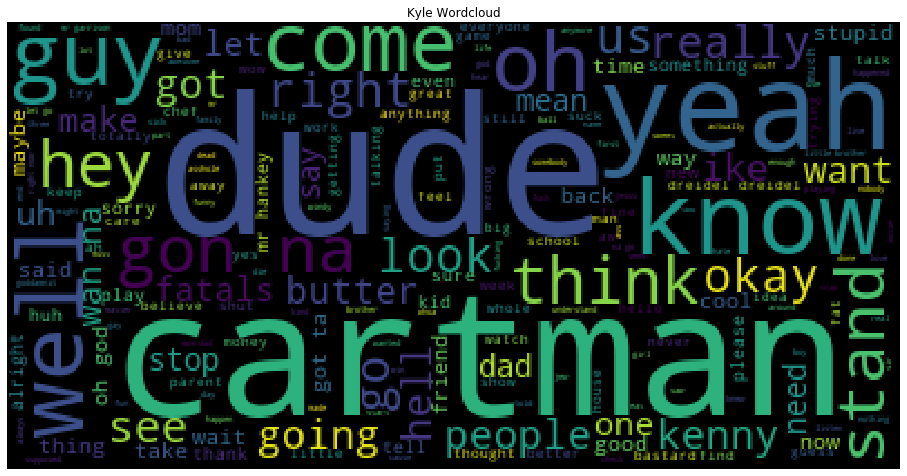

In [40]:
#Wordcloud
wordcloud_kyle = WordCloud().generate(kyle['word_tokens'].to_string())
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud_kyle)
plt.axis("off")
plt.savefig('Kyle_Wordcloud.png')
plt.title('Kyle Wordcloud')
plt.show()

In [41]:
kyle_lists =  kyle['word_tokens']
kyle_words = []
for kyle_wordList in kyle_lists:
    kyle_words += kyle_wordList
kyle_bigram = ngrams(kyle_words,2)
kyle_bigram_top = Counter(kyle_bigram).most_common(10)
for word, count in kyle_bigram_top:
    print(word, ":", count)

('gon', 'na') : 264
('wan', 'na') : 106
('come', 'on') : 104
('oh', 'god') : 77
('got', 'ta') : 73
('mr', 'hankey') : 65
('dreidel', 'dreidel') : 57
('little', 'brother') : 40
('right', 'now') : 35
('let', 'go') : 33


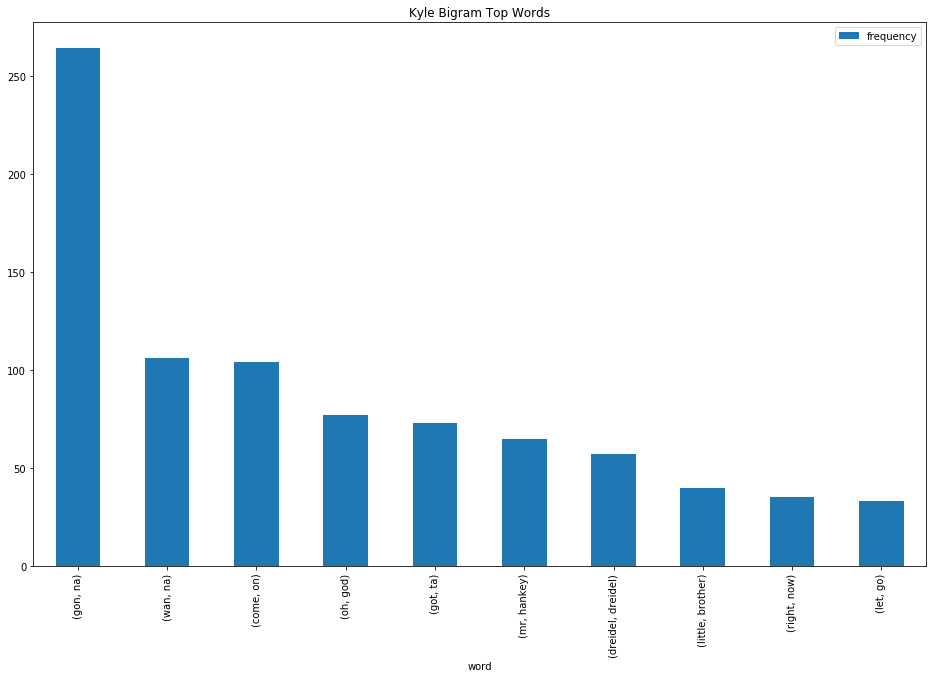

In [42]:
kyle_bi = pd.DataFrame(kyle_bigram_top, columns = ['word', 'frequency'])
kyle_bi.plot(kind='bar', x='word', figsize=(16,10), title='Kyle Bigram Top Words')
plt.savefig('Kyle_Bigram.png')

In [44]:
kyle_trigram = ngrams(kyle_words,3)
kyle_trigram_top = Counter(kyle_trigram).most_common(10)
for word, count in kyle_trigram_top:
    print(word, ":", count)

('dreidel', 'dreidel', 'dreidel') : 33
('gon', 'na', 'get') : 23
('dude', 'gon', 'na') : 16
('wan', 'na', 'go') : 15
('gon', 'na', 'go') : 14
('dreidel', 'made', 'clay') : 13
('got', 'ta', 'go') : 13
('learned', 'something', 'today') : 12
('yummy', 'yummy', 'yummy') : 12
('dreidel', 'dreidel', 'made') : 11


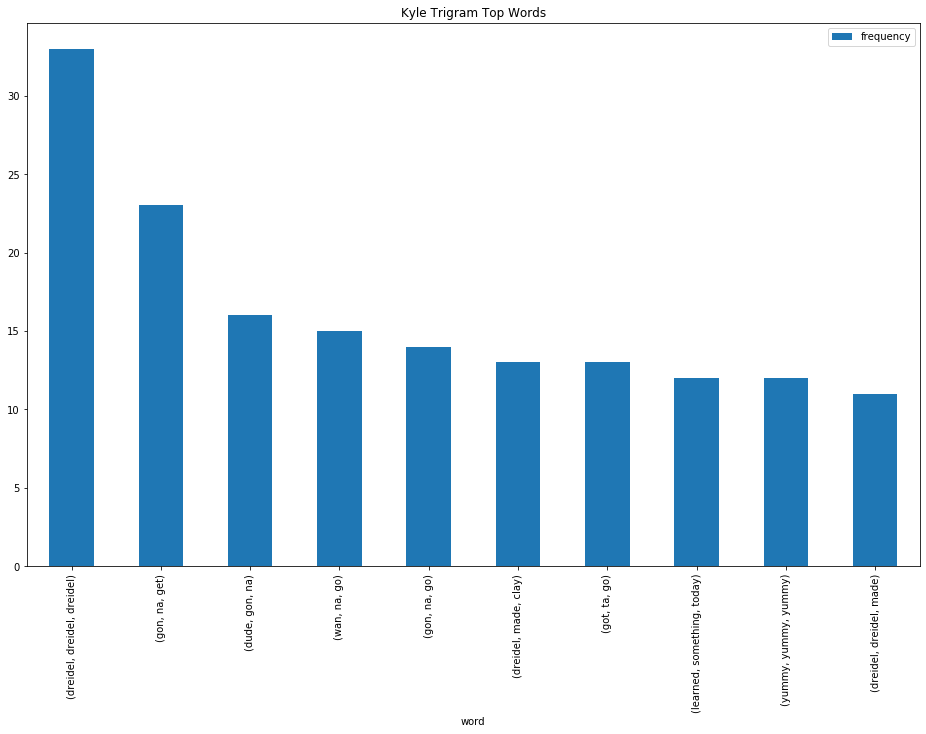

In [45]:
kyle_tri = pd.DataFrame(kyle_trigram_top, columns = ['word', 'frequency'])
kyle_tri.plot(kind='bar', x='word', figsize=(16,10), title='Kyle Trigram Top Words')
plt.savefig('Kyle_Trigram.png')

In [46]:
#Bag of Word Model

In [47]:
kyle_vec = CountVectorizer()
kyle_bag = kyle_vec.fit_transform(kyle['token_string'])
kyle_sum_words = kyle_bag.sum(axis=0)
kyle_words_freq = [(word, kyle_sum_words[0, idx]) for word, idx in kyle_vec.vocabulary_.items()]
kyle_words_freq = np.array(sorted(kyle_words_freq, key = lambda x: x[1], reverse=True))

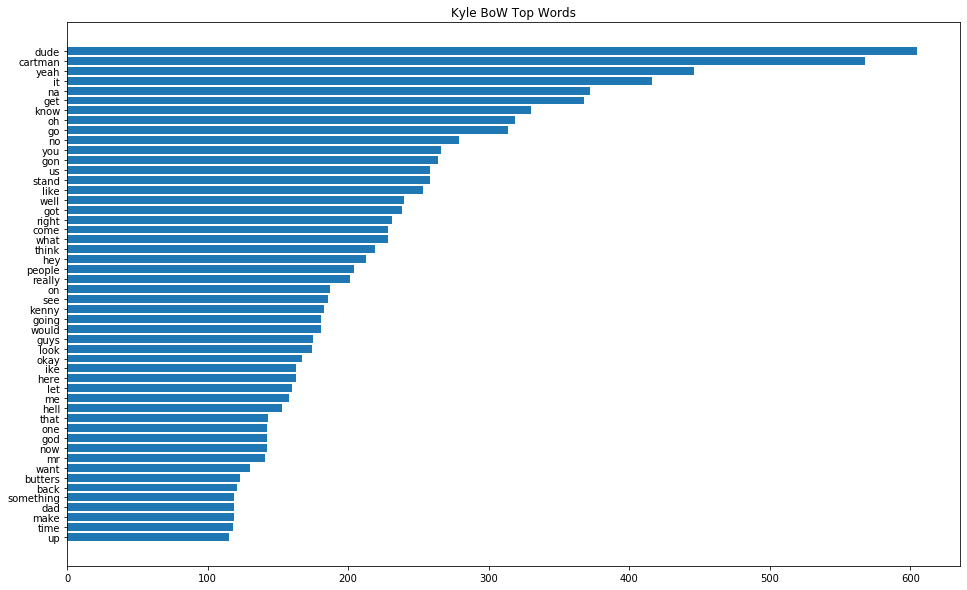

In [48]:
n = 50
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), kyle_words_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=kyle_words_freq[:n, 0])
plt.savefig('Kyle_BOW.png')
plt.title('Kyle BoW Top Words')
plt.show()

In [49]:
#Create New Dataframe of Bag of Words Array
kyle_bag_of_words = kyle_vec.fit_transform(kyle['token_string']).toarray()
kyle_features_bag = kyle_vec.get_feature_names()
kyle_bow = pd.DataFrame(kyle_bag_of_words, columns = kyle_features_bag)
kyle_bow.head()

,aaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaah,aaaaaaaaaaaah,aaaaaaaaaah,aaaaaaah,...,yyeah,yyeeaahh,yyou,zither,zombie,zombies,zookeeper,zoozoo,zygous,über
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
#TF-IDF
kyle_vect = TfidfVectorizer()
kyle_tfidf = kyle_vect.fit_transform(kyle['token_string'])
kyle_sum_tfidf = kyle_tfidf.sum(axis=0)
kyle_tfidf_freq = [(word, kyle_sum_tfidf[0, idx]) for word, idx in kyle_vect.vocabulary_.items()]
kyle_tfidf_freq = np.array(sorted(kyle_tfidf_freq, key = lambda x: x[1], reverse=True))

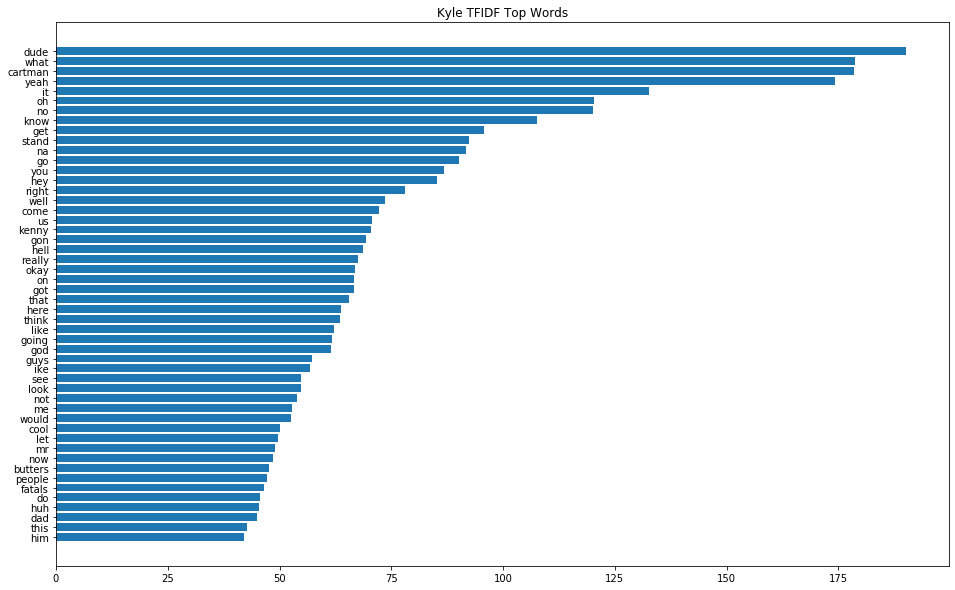

In [51]:
n = 50
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), kyle_tfidf_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=kyle_tfidf_freq[:n, 0])
plt.savefig('Kyle_TFIDF.png')
plt.title('Kyle TFIDF Top Words')
plt.show()

In [52]:
#Create New Dataframe of TFIDF Array
kyle_vectorize = kyle_vect.fit_transform(kyle['token_string']).toarray()
kyle_features_tfidf = kyle_vect.get_feature_names()
kyle_tfidf = pd.DataFrame(kyle_vectorize, columns = kyle_features_tfidf)
kyle_tfidf.head()

,aaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaah,aaaaaaaaaaaah,aaaaaaaaaah,aaaaaaah,...,yyeah,yyeeaahh,yyou,zither,zombie,zombies,zookeeper,zoozoo,zygous,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Stan

In [53]:
#Dialogue spoken by Stan
sta = southpark['Character'] == 'Stan'
stan = southpark[sta]
stan.head()

,Season,Episode,Character,Line
6,1,1,Stan,What's a dildo?\n
11,1,1,Stan,"What's a dildo, Kenny?\n"
14,1,1,Stan,"Dude, that kicks ass!\n"
18,1,1,Stan,"Whoa, Cartman! Looks like you didn't get much ..."
22,1,1,Stan,Dude! Visitors!\n


In [54]:
#Reset index
stan = stan.reset_index(drop=True)
stan.head()

,Season,Episode,Character,Line
0,1,1,Stan,What's a dildo?\n
1,1,1,Stan,"What's a dildo, Kenny?\n"
2,1,1,Stan,"Dude, that kicks ass!\n"
3,1,1,Stan,"Whoa, Cartman! Looks like you didn't get much ..."
4,1,1,Stan,Dude! Visitors!\n


In [55]:
# Expand Contractions
stan['Line_process'] = stan['Line'].apply(decontracted)
stan['Line_process'].head(25)

0                                    What is a dildo?\n
1                             What is a dildo, Kenny?\n
2                               Dude, that kicks ass!\n
3     Whoa, Cartman! Looks like you did not get much...
4                                     Dude! Visitors!\n
5     That was not a dream Cartman, those were visit...
6                                  Visitors are real.\n
7             What is gonna be for lunch today, Chef?\n
8                        They took him on their ship.\n
9     Dude, they did, huh? Aliens stuck stuff up you...
10                       Good morning, Miss Crabtree.\n
11                        Oh, do not worry about him.\n
12                      Yeah, whatever, ya fat bitch.\n
13                          I said I have a bad itch.\n
14                                          Visitors!\n
15      Cartman, are those the same visitors you saw?\n
16    Well, we can not do anything for now, that fat...
17               Uh, I said that rabbits eat let

In [56]:
#Lowercase
stan['Line_process'] = stan['Line_process'].apply(lambda x: " ".join(x.lower() for x in x.split()))
stan['Line_process'].head(25)

0                                      what is a dildo?
1                               what is a dildo, kenny?
2                                 dude, that kicks ass!
3     whoa, cartman! looks like you did not get much...
4                                       dude! visitors!
5     that was not a dream cartman, those were visit...
6                                    visitors are real.
7               what is gonna be for lunch today, chef?
8                          they took him on their ship.
9     dude, they did, huh? aliens stuck stuff up you...
10                         good morning, miss crabtree.
11                          oh, do not worry about him.
12                        yeah, whatever, ya fat bitch.
13                            i said i have a bad itch.
14                                            visitors!
15        cartman, are those the same visitors you saw?
16    well, we can not do anything for now, that fat...
17                 uh, i said that rabbits eat l

In [57]:
#Remove numbers
stan['Line_process'] = stan['Line_process'].str.replace('\d+', '')
stan['Line_process'].head(25)

0                                      what is a dildo?
1                               what is a dildo, kenny?
2                                 dude, that kicks ass!
3     whoa, cartman! looks like you did not get much...
4                                       dude! visitors!
5     that was not a dream cartman, those were visit...
6                                    visitors are real.
7               what is gonna be for lunch today, chef?
8                          they took him on their ship.
9     dude, they did, huh? aliens stuck stuff up you...
10                         good morning, miss crabtree.
11                          oh, do not worry about him.
12                        yeah, whatever, ya fat bitch.
13                            i said i have a bad itch.
14                                            visitors!
15        cartman, are those the same visitors you saw?
16    well, we can not do anything for now, that fat...
17                 uh, i said that rabbits eat l

In [58]:
#Spellchecker
stan["Line_process"] = [' '.join([spell(i) for i in x.split()]) for x in stan['Line_process']]
stan['Line_process'].head(25)

0                                      what is a dildo?
1                               what is a dildo, kenny?
2                                 dude, that kicks ass!
3     whoa, cartman! looks like you did not get much...
4                                       dude! visitors!
5     that was not a dream cartman, those were visit...
6                                    visitors are real.
7               what is gonna be for lunch today, chef?
8                          they took him on their ship.
9     dude, they did, huh? aliens stuck stuff up you...
10                          good morning, miss rantree.
11                          oh, do not worry about him.
12                        yeah, whatever, ya fat bitch.
13                            i said i have a bad itch.
14                                            visitors!
15        cartman, are those the same visitors you saw?
16    well, we can not do anything for now, that fat...
17                 uh, i said that rabbits eat l

In [59]:
#Remove Stop Words
stan['Line_process'] = stan['Line_process'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
stan['Line_process'].head(25)

0                                                dildo?
1                                         dildo, kenny?
2                                      dude, kicks ass!
3     whoa, cartman! looks like get much sleep last ...
4                                       dude! visitors!
5                              dream cartman, visitors!
6                                        visitors real.
7                              gonna lunch today, chef?
8                                            took ship.
9               dude, did, huh? aliens stuck stuff ass!
10                          good morning, miss rantree.
11                                       oh, worry him.
12                        yeah, whatever, ya fat bitch.
13                                       said bad itch.
14                                            visitors!
15                               cartman, visitors saw?
16                well, anything now, fat bitch let us.
17                        uh, said rabbits eat l

In [60]:
#Remove Punctuation
stan['Line_process'] = stan['Line_process'].str.replace('[^\w\s]','')
stan['Line_process'].head(25)

0                                                 dildo
1                                           dildo kenny
2                                        dude kicks ass
3     whoa cartman looks like get much sleep last night
4                                         dude visitors
5                                dream cartman visitors
6                                         visitors real
7                                gonna lunch today chef
8                                             took ship
9                   dude did huh aliens stuck stuff ass
10                            good morning miss rantree
11                                         oh worry him
12                           yeah whatever ya fat bitch
13                                        said bad itch
14                                             visitors
15                                 cartman visitors saw
16                   well anything now fat bitch let us
17                          uh said rabbits eat 

In [61]:
#Tokenize
stan['word_tokens'] = stan['Line_process'].apply(word_tokenize)

In [62]:
stan['word_tokens'].head(25)

0                                               [dildo]
1                                        [dildo, kenny]
2                                    [dude, kicks, ass]
3     [whoa, cartman, looks, like, get, much, sleep,...
4                                      [dude, visitors]
5                            [dream, cartman, visitors]
6                                      [visitors, real]
7                         [gon, na, lunch, today, chef]
8                                          [took, ship]
9           [dude, did, huh, aliens, stuck, stuff, ass]
10                       [good, morning, miss, rantree]
11                                     [oh, worry, him]
12                     [yeah, whatever, ya, fat, bitch]
13                                    [said, bad, itch]
14                                           [visitors]
15                             [cartman, visitors, saw]
16           [well, anything, now, fat, bitch, let, us]
17                    [uh, said, rabbits, eat, l

In [63]:
#Lemmatize
stan['word_tokens'].apply(lemmatize_text).head(25)

0                                               [dildo]
1                                        [dildo, kenny]
2                                      [dude, kick, as]
3     [whoa, cartman, look, like, get, much, sleep, ...
4                                       [dude, visitor]
5                             [dream, cartman, visitor]
6                                       [visitor, real]
7                         [gon, na, lunch, today, chef]
8                                          [took, ship]
9             [dude, did, huh, alien, stuck, stuff, as]
10                       [good, morning, miss, rantree]
11                                     [oh, worry, him]
12                     [yeah, whatever, ya, fat, bitch]
13                                    [said, bad, itch]
14                                            [visitor]
15                              [cartman, visitor, saw]
16            [well, anything, now, fat, bitch, let, u]
17                     [uh, said, rabbit, eat, l

In [64]:
#Convert Word Tokens to String
stan['token_string'] = stan['word_tokens'].apply(lambda x: md.detokenize(x, return_str=True))
stan['token_string'].head(25)

0                                                 dildo
1                                           dildo kenny
2                                        dude kicks ass
3     whoa cartman looks like get much sleep last night
4                                         dude visitors
5                                dream cartman visitors
6                                         visitors real
7                               gon na lunch today chef
8                                             took ship
9                   dude did huh aliens stuck stuff ass
10                            good morning miss rantree
11                                         oh worry him
12                           yeah whatever ya fat bitch
13                                        said bad itch
14                                             visitors
15                                 cartman visitors saw
16                   well anything now fat bitch let us
17                          uh said rabbits eat 

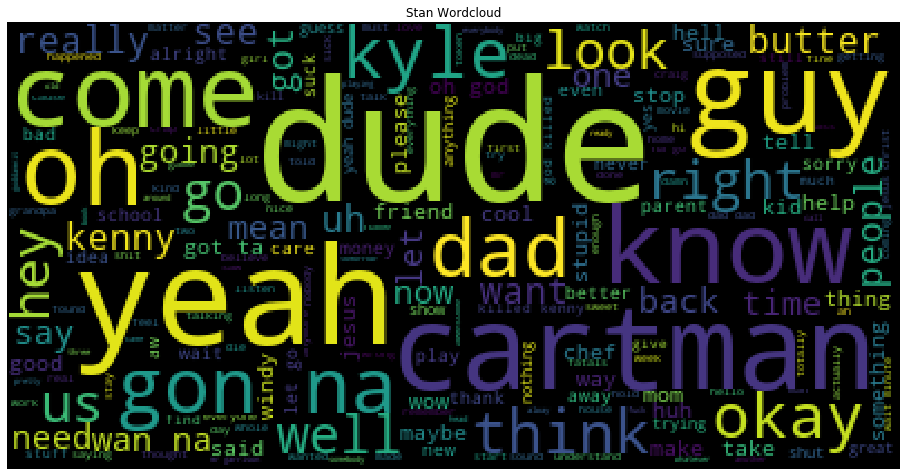

In [65]:
#Wordcloud
wordcloud_stan = WordCloud().generate(stan['word_tokens'].to_string())
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud_stan)
plt.axis("off")
plt.savefig('Stan_Wordcloud.png')
plt.title('Stan Wordcloud')
plt.show()

In [66]:
stan_lists =  stan['word_tokens']
stan_words = []
for stan_wordList in stan_lists:
    stan_words += stan_wordList
stan_bigram = ngrams(stan_words,2)
stan_bigram_top = Counter(stan_bigram).most_common(10)
for word, count in stan_bigram_top:
    print(word, ":", count)

('gon', 'na') : 337
('come', 'on') : 192
('wan', 'na') : 131
('got', 'ta') : 114
('oh', 'god') : 85
('let', 'go') : 62
('oh', 'no') : 48
('yeah', 'dude') : 45
('killed', 'kenny') : 43
('god', 'killed') : 42


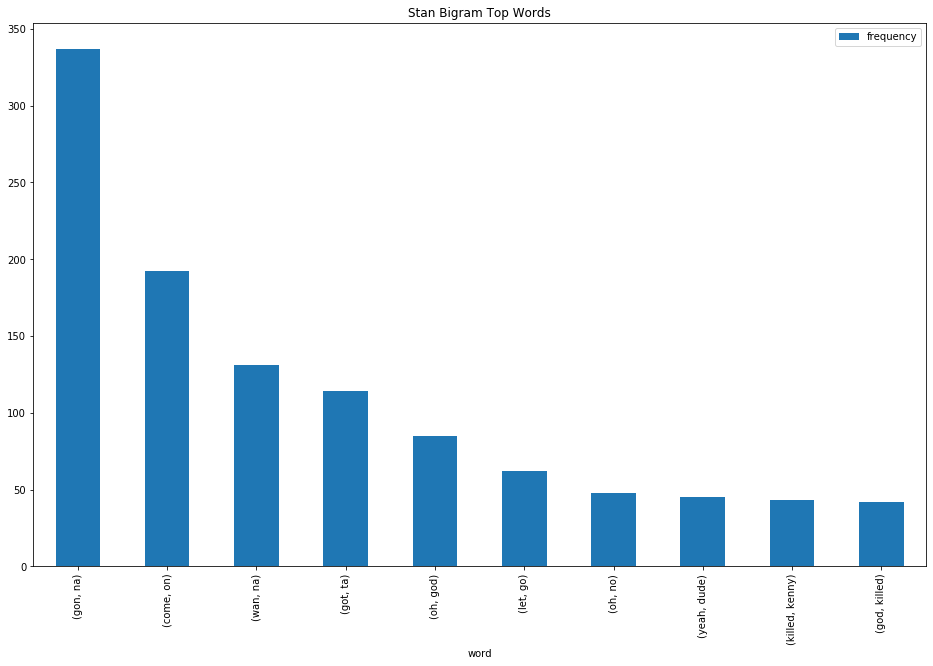

In [67]:
stan_bi = pd.DataFrame(stan_bigram_top, columns = ['word', 'frequency'])
stan_bi.plot(kind='bar', x='word', figsize=(16,10), title='Stan Bigram Top Words')
plt.savefig('Stan_Bigram.png')

In [68]:
stan_trigram = ngrams(stan_words,3)
stan_trigram_top = Counter(stan_trigram).most_common(10)
for word, count in stan_trigram_top:
    print(word, ":", count)

('oh', 'god', 'killed') : 41
('god', 'killed', 'kenny') : 38
('got', 'ta', 'get') : 28
('come', 'on', 'guys') : 26
('gon', 'na', 'go') : 24
('dude', 'gon', 'na') : 18
('come', 'on', 'got') : 17
('come', 'on', 'dude') : 16
('gon', 'na', 'get') : 16
('semigod', 'semigod', 'semigod') : 16


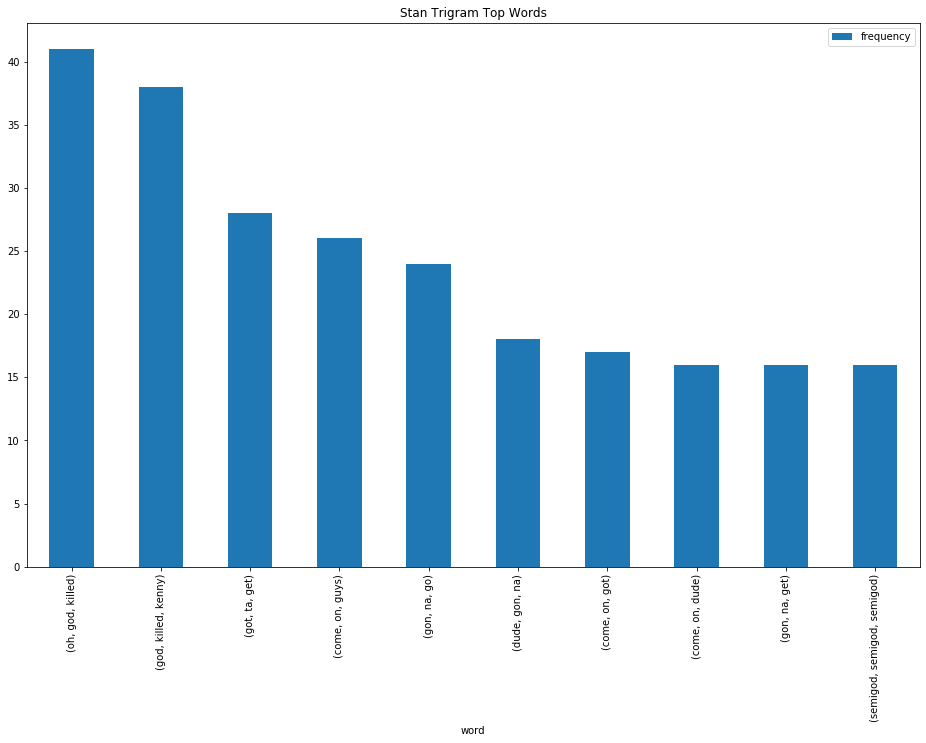

In [69]:
stan_tri = pd.DataFrame(stan_trigram_top, columns = ['word', 'frequency'])
stan_tri.plot(kind='bar', x='word', figsize=(16,10), title='Stan Trigram Top Words')
plt.savefig('Stan_Trigram.png')

In [70]:
#Bag of Word Model

In [71]:
stan_vec = CountVectorizer()
stan_bag_of_words = stan_vec.fit_transform(stan['token_string'])
stan_sum_words = stan_bag_of_words.sum(axis=0)
stan_words_freq = [(word, stan_sum_words[0, idx]) for word, idx in stan_vec.vocabulary_.items()]
stan_words_freq = np.array(sorted(stan_words_freq, key = lambda x: x[1], reverse=True))

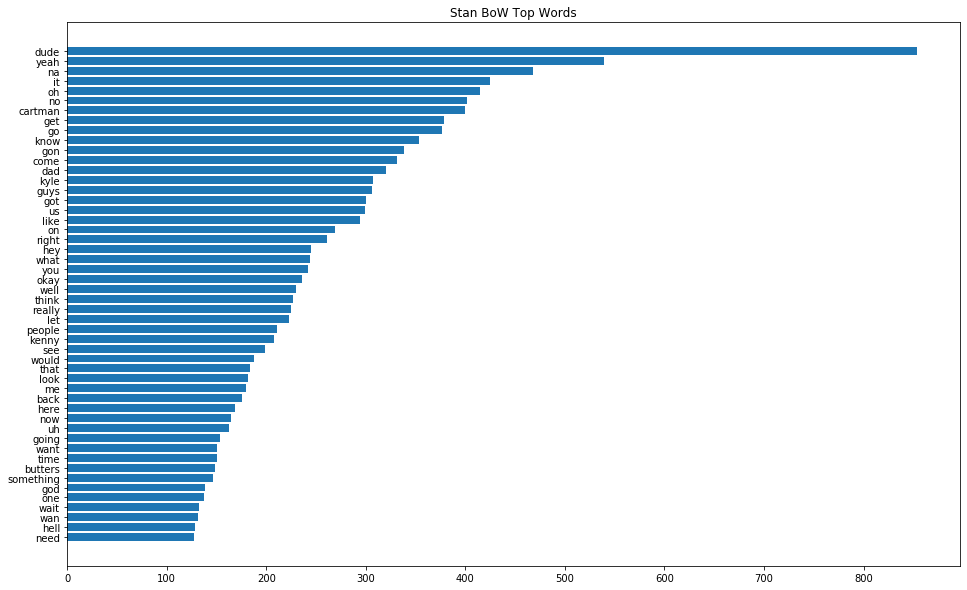

In [72]:
n = 50
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), stan_words_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=stan_words_freq[:n, 0])
plt.savefig('Stan_BOW.png')
plt.title('Stan BoW Top Words')
plt.show()

In [73]:
#Create New Dataframe of Bag of Words Array
stan_bag_of_words = stan_vec.fit_transform(stan['token_string']).toarray()
stan_bow_features = stan_vec.get_feature_names()
stan_bow = pd.DataFrame(stan_bag_of_words, columns = stan_bow_features)
stan_bow.head()

,aa,aaa,aaaaaaa,aaaaaaaa,aaaaaaaaaa,aaaaaaaaaaaaaaaa,aaaaaaaah,aaaaaaah,aaaaaagh,aaaaahh,...,yup,yyou,zanza,zeppoli,zillion,zombie,zombies,zone,zoozoo,ürecool
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
#TF-IDF
stan_vect = TfidfVectorizer()
stan_tfidf = stan_vect.fit_transform(stan['token_string'])
stan_sum_tfidf = stan_tfidf.sum(axis=0)
stan_tfidf_freq = [(word, stan_sum_tfidf[0, idx]) for word, idx in stan_vect.vocabulary_.items()]
stan_tfidf_freq = np.array(sorted(stan_tfidf_freq, key = lambda x: x[1], reverse=True))

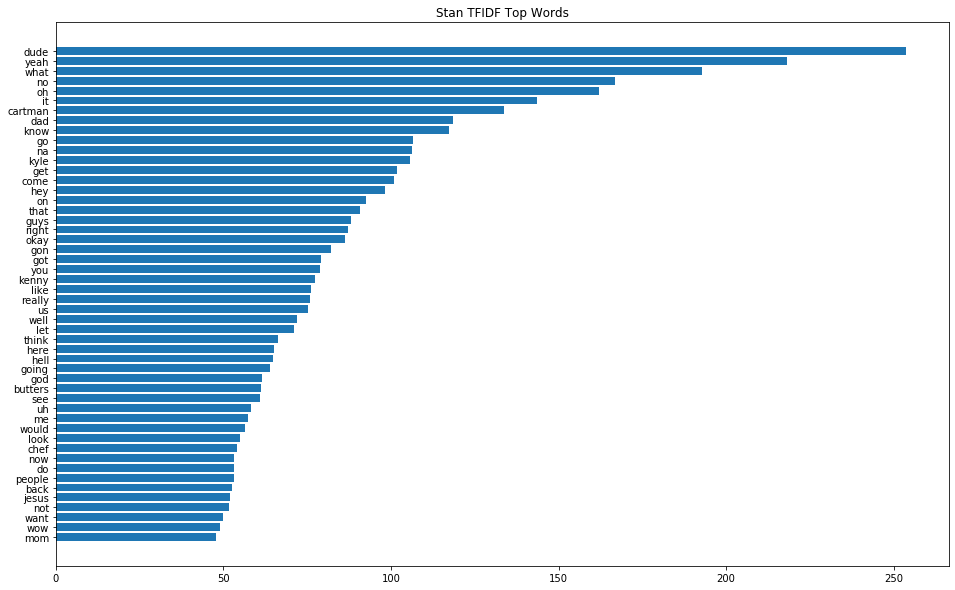

In [75]:
n = 50
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), stan_tfidf_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=stan_tfidf_freq[:n, 0])
plt.savefig('Stan_TFIDF.png')
plt.title('Stan TFIDF Top Words')
plt.show()

In [76]:
#Create New Dataframe of TFIDF Array
stan_vectorize = stan_vect.fit_transform(stan['token_string']).toarray()
stan_tfidf_features = stan_vect.get_feature_names()
stan_tfidf = pd.DataFrame(stan_vectorize, columns = stan_tfidf_features)
stan_tfidf.head()

,aa,aaa,aaaaaaa,aaaaaaaa,aaaaaaaaaa,aaaaaaaaaaaaaaaa,aaaaaaaah,aaaaaaah,aaaaaagh,aaaaahh,...,yup,yyou,zanza,zeppoli,zillion,zombie,zombies,zone,zoozoo,ürecool
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Chatbots

In [77]:
#Chat Function Using Bag of Words Model
def cartman_chat_bow(question):
    cartman_lemma = text_normalization(question)
    cartman_bagg = cartman_vec.transform([cartman_lemma]).toarray()
    cartman_cos = 1 - pairwise_distances(cartman_bow, cartman_bagg, metric = 'cosine')
    cartman_index_val = cartman_cos.argmax()
    return cartman['Line'].loc[cartman_index_val]

In [78]:
#Chat Function Using TFIDF Model
def cartman_chat_tfidf(question):
    cartman_lem = text_normalization(question)
    cartman_tf = cartman_vect.transform([cartman_lem]).toarray()
    cartman_cosine = 1 - pairwise_distances(cartman_bow, cartman_tf, metric = 'cosine')
    cartman_index_value = cartman_cosine.argmax()
    return cartman['Line'].loc[cartman_index_value]

In [79]:
#Chat Function Using Bag of Words Model
def kyle_chat_bow(question):
    kyle_lemma = text_normalization(question)
    kyle_bagg = kyle_vec.transform([kyle_lemma]).toarray()
    kyle_cos = 1 - pairwise_distances(kyle_bow, kyle_bagg, metric = 'cosine')
    kyle_index_val = kyle_cos.argmax()
    return kyle['Line'].loc[kyle_index_val]

In [80]:
#Chat Function Using TFIDF Model
def kyle_chat_tfidf(question):
    kyle_lem = text_normalization(question)
    kyle_tf = kyle_vect.transform([kyle_lem]).toarray()
    kyle_cosine = 1 - pairwise_distances(kyle_bow, kyle_tf, metric = 'cosine')
    kyle_index_value = kyle_cosine.argmax()
    return kyle['Line'].loc[kyle_index_value]

In [81]:
#Chat Function Using Bag of Words Model
def stan_chat_bow(question):
    stan_lemma = text_normalization(question)
    stan_bagg = vec.transform([lemma]).toarray()
    stan_cos = 1 - pairwise_distances(stan_bow, stan_bagg, metric = 'cosine')
    stan_index_val = stan_cos.argmax()
    return stan['Line'].loc[stan_index_val]

In [82]:
#Chat Function Using TFIDF Model
def stan_chat_tfidf(question):
    stan_lem = text_normalization(question)
    stan_tf = stan_vect.transform([stan_lem]).toarray()
    stan_cosine = 1 - pairwise_distances(stan_bow, stan_tf, metric = 'cosine')
    stan_index_value = stan_cosine.argmax()
    return stan['Line'].loc[stan_index_value]

In [ ]:
#Chatbots Talking to Each Other

In [ ]:
question = input('What is your question?')